# VGG16 Transfer Learning Image Classification Model
Using the pretrained model, our goal is to utilize transfer learning to yield a more accurate model that recognizes genres from our spectrograms.

Source for code guidance: https://www.kaggle.com/code/danaelisanicolas/cnn-part-4-training-and-modelling-with-vgg16/notebook.

Import libraries

In [1]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import metrics

from sklearn.utils import class_weight
from collections import Counter

import matplotlib.pyplot as plt

from os import listdir
from os.path import isfile, join

import pandas as pd

Prepare the data with target size of 224 by 224 (requiredment for VGG16)

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
train_loc = '/content/gdrive/MyDrive/split_image_data/train'
val_loc = '/content/gdrive/MyDrive/split_image_data/val'

In [4]:
# Train
trdata = ImageDataGenerator()
traindata = trdata.flow_from_directory(directory=train_loc, target_size=(224,224))

# Val
vldata = ImageDataGenerator()
valdata = vldata.flow_from_directory(directory=val_loc, target_size=(224,224))

Found 699 images belonging to 10 classes.
Found 150 images belonging to 10 classes.


In [5]:
categories = ['blues', 'classical', 'country', 'disco', 'hiphop',
               'jazz', 'metal', 'pop', 'reggae', 'rock']
categories

['blues',
 'classical',
 'country',
 'disco',
 'hiphop',
 'jazz',
 'metal',
 'pop',
 'reggae',
 'rock']

Use weights from pretrained model


In [6]:
vgg16 = VGG16(weights='imagenet')
vgg16.summary()

x  = vgg16.get_layer('fc2').output
prediction = Dense(10, activation='softmax', name='predictions')(x)

model = Model(inputs=vgg16.input, outputs=prediction)

553467096/553467096 [==============================] - 14s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

20/23 layers are learnable

In [7]:
for layer in model.layers:
    layer.trainable = False

for layer in model.layers[-20:]:
    layer.trainable = True
    print("Layer '%s' is trainable" % layer.name)

Layer 'block1_pool' is trainable
Layer 'block2_conv1' is trainable
Layer 'block2_conv2' is trainable
Layer 'block2_pool' is trainable
Layer 'block3_conv1' is trainable
Layer 'block3_conv2' is trainable
Layer 'block3_conv3' is trainable
Layer 'block3_pool' is trainable
Layer 'block4_conv1' is trainable
Layer 'block4_conv2' is trainable
Layer 'block4_conv3' is trainable
Layer 'block4_pool' is trainable
Layer 'block5_conv1' is trainable
Layer 'block5_conv2' is trainable
Layer 'block5_conv3' is trainable
Layer 'block5_pool' is trainable
Layer 'flatten' is trainable
Layer 'fc1' is trainable
Layer 'fc2' is trainable
Layer 'predictions' is trainable


Adam as optimizer with a learning rate of 0.001

In [8]:
opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss=categorical_crossentropy,
              metrics=['accuracy', 'mae'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Defining our monitor and early stopping point.

In [9]:
checkpoint = ModelCheckpoint("vgg16_base_res.h5", monitor='val_accuracy', verbose=1,
                             save_best_only=True, save_weights_only=False, mode='auto')
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto')

Our data is balanced, but here are additional weights if we use this with an imbalanced data set--this is mostly for exploration

In [10]:
counter = Counter(traindata.classes)
max_val = float(max(counter.values()))
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}
class_weights

{0: 1.1014492753623188,
 1: 1.0704225352112675,
 2: 1.1692307692307693,
 3: 1.1875,
 4: 1.0704225352112675,
 5: 1.1515151515151516,
 6: 1.0133333333333334,
 7: 1.0555555555555556,
 8: 1.0857142857142856,
 9: 1.0}

Run Model!

In [11]:
hist = model.fit(traindata, steps_per_epoch=traindata.samples//traindata.batch_size, validation_data=valdata,
                 class_weight=class_weights, validation_steps=valdata.samples//valdata.batch_size,
                 epochs=150,callbacks=[checkpoint,early])

Epoch 1/150
21/21 [==============================] - ETA: 0s - loss: 46.9070 - accuracy: 0.1064 - mae: 0.1804
Epoch 1: val_accuracy improved from -inf to 0.10938, saving model to vgg16_base_res.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


21/21 [==============================] - 289s 13s/step - loss: 46.9070 - accuracy: 0.1064 - mae: 0.1804 - val_loss: 2.4421 - val_accuracy: 0.1094 - val_mae: 0.1789
Epoch 2/150
21/21 [==============================] - ETA: 0s - loss: 3.0618 - accuracy: 0.0765 - mae: 0.1806
Epoch 2: val_accuracy did not improve from 0.10938
21/21 [==============================] - 8s 382ms/step - loss: 3.0618 - accuracy: 0.0765 - mae: 0.1806 - val_loss: 2.6466 - val_accuracy: 0.0859 - val_mae: 0.1792
Epoch 3/150
21/21 [==============================] - ETA: 0s - loss: 2.6064 - accuracy: 0.1304 - mae: 0.1773
Epoch 3: val_accuracy improved from 0.10938 to 0.16406, saving model to vgg16_base_res.h5
21/21 [==============================] - 22s 1s/step - loss: 2.6064 - accuracy: 0.1304 - mae: 0.1773 - val_loss: 2.2871 - val_accuracy: 0.1641 - val_mae: 0.1743
Epoch 4/150
21/21 [==============================] - ETA: 0s - loss: 2.3942 - accuracy: 0.1604 - mae: 0.1727
Epoch 4: val_accuracy improved from 0.16406 

In [14]:
# Test
test_loc = '/content/gdrive/MyDrive/split_image_data/test'
tsdata = ImageDataGenerator()
testdata = vldata.flow_from_directory(directory=test_loc, target_size=(224,224))

results = model.evaluate(testdata)

Found 150 images belonging to 10 classes.
5/5 [==============================] - 44s 11s/step - loss: 3.8014 - accuracy: 0.4267 - mae: 0.1188


Plots

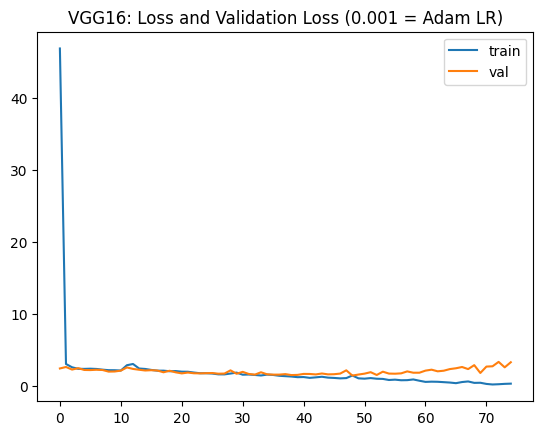

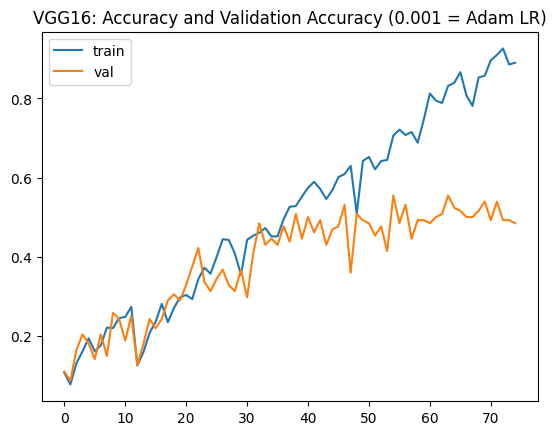

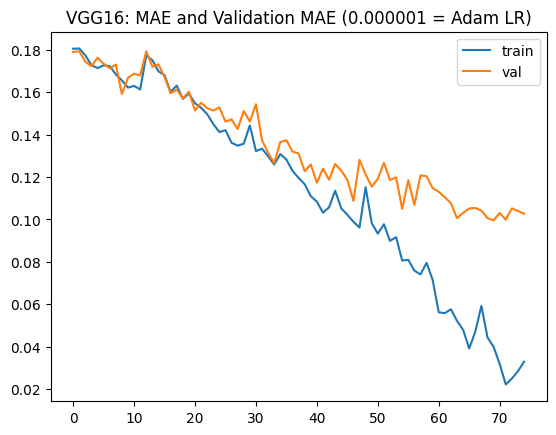

In [13]:
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='val')
plt.title('VGG16: Loss and Validation Loss (0.001 = Adam LR)')
plt.legend();
plt.show()

plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='val')
plt.title('VGG16: Accuracy and Validation Accuracy (0.001 = Adam LR)')
plt.legend();
plt.show()

plt.plot(hist.history['mae'], label='train')
plt.plot(hist.history['val_mae'], label='val')
plt.title('VGG16: MAE and Validation MAE (0.000001 = Adam LR)')
plt.legend();
plt.show()